In [1]:
import qutip as qt
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import time as time

import matplotlib.ticker as ticker


from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm
from scipy.integrate import simpson

%matplotlib inline

In [2]:



plt.rcParams.update({
    "text.usetex": True,
    #"text.latex.preamble": r"\boldmath",
    #"font.family": "sans-serif",
    "mathtext.fontset" : "stix",
    "font.family" : "lmodern", #   "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #"text.latex.preamble": r"\usepackage[T1]{fontenc}  \usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.4,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.4,     # distance to the minor tick label in points
    #
    "xtick.major.size": 5.5, 
    "ytick.major.size": 5.5,
    
    "xtick.minor.size": 3.5, 
    "ytick.minor.size": 3.5,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "white",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})



In [3]:


def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], np.conjugate(e_mat)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], e_mat/np.trace(e_mat)
        
    else: raise ValueError('You have to choose or left or right')

###############
####### Coding 
###############

In [4]:

def Apply_Tilted_lindblad_normed(t, rho, args):
    """
    Apply the tilted Lindblad equation to a density matrix.

    Parameters:
    t: float
        Time at which the Lindblad equation is evaluated.
    rho: array-like
        The density matrix at time t, flattened to a 1D array.
    args: dictionary
        Additional arguments required for the tilted Lindblad operator.

    Returns:
    drho: array-like
        The time derivative of the density matrix, flattened to a 1D array.
    """
    
    # Compute the time derivative of rho using the tilted Lindblad operator
    drho = Tilted_lindbladian(t, args) @ rho
    
    drho = drho - rho * np.trace(np.reshape(drho, (2,2)))

    # Return the time derivative of rho, flattened back to a 1D array
    return drho


def Apply_Tilted_lindblad(t, rho, args):
    """
    Apply the tilted Lindblad equation to a density matrix.

    Parameters:
    t: float
        Time at which the Lindblad equation is evaluated.
    rho: array-like
        The density matrix at time t, flattened to a 1D array.
    args: dictionary
        Additional arguments required for the tilted Lindblad operator.

    Returns:
    drho: array-like
        The time derivative of the density matrix, flattened to a 1D array.
    """
    
    # Compute the time derivative of rho using the tilted Lindblad operator
    drho = Tilted_lindbladian(t, args) @ rho
    
    # Return the time derivative of rho, flattened back to a 1D array
    return drho

# Calculating theta by controled evolution 

In [5]:
def Direct_SCGF_calculation(rho_0, tlist, args):
    """
    This function calculates the scaled cumulant generating function (SCGF) directly 
    for a given initial state and a specific Lindblad operator. 
    
    Parameters:
    rho_0: array-like
        Initial state (density matrix) of the system, flattened to a 1D array.
    ti: float
        Initial time for the calculation.
    tf: float
        Final time for the calculation.
    dt: float
        Time step for the calculation.
    args: arguments for creating the quantum and auxiliary system 

        
    Returns:
    theta: float
        Scaled cumulant generating function (SCGF) for the given initial state and Lindblad operator.
    """
    # Flatten the initial state
    rho_0 = rho_0.full().flatten()

    # get dt 
    dt = tlist[1] - tlist[0]
    theta = [0]

    rhos = [qt.Qobj(rho_0.reshape((2,2)))]

    # Initial step 
    for t in tlist[1:]:

        Lindblad_s = Tilted_lindbladian(t, args)
        # Solve the differential equation for the next time step
        rho_0 = solve_ivp(lambda t, rho, args: np.dot(Lindblad_s, rho), 
                t_span=(t, t + dt), 
                y0=rho_0, 
                t_eval=[t, t + dt], 
                args=(args, ), 
                method="DOP853", 
                rtol=10e-12, 
                atol=10e-12).y.T[-1]
        
        # Calculate the trace and normalize the state
        aux_rho = qt.Qobj(rho_0.reshape((2,2)))
        
        rho_0 = (aux_rho/aux_rho.norm()).full().flatten()
    
        # Update the SCGF
        theta.append(np.log(aux_rho.tr()))
        rhos.append(qt.Qobj(rho_0.reshape((2,2))))
        
        # Move to the next time step
        #t += dt
        
    return theta, rhos


In [6]:
####
#### Vectorized tilted operator
####

def Tilted_lindbladian(t, args):

    H = args["H"]
    Lm = args["Lm"] 
    H0 = H[0] 
    H1 = H[1][0]

    driving_t = H[1][1]

    Ide = qt.qeye(2)

    Flat_H0    = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()  

    Flat_H1    = -1.0j*(qt.tensor(Ide, H1) - qt.tensor(H1.trans(), Ide)).full()  

    Flat_inco_m = -(1.0/2.0)*(qt.tensor(Ide, Lm.dag()*Lm) + qt.tensor((Lm.dag()*Lm).trans(), Ide)).full()

    Flat_jump_m = (qt.tensor(Lm.conj(),Lm)).full()

       
    Wst = (Flat_H0 * args["omega"]
         + Flat_H1 * driving_t(t, args)
         + Flat_inco_m * args["gamma"] 
         + Flat_jump_m * args["gamma"] * np.exp(-args["s"]))

    return Wst.astype(complex)


# Get exact diagonalization

In [7]:

def get_exact_diagonalization(tlist, args):
    #### Exact diagonalization 
    e_vals = []
    e_vecs = []

    for t in tlist:
        Ws = Tilted_lindbladian(t, args)
        e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
        e_vals.append(e_val)
        e_vecs.append(qt.Qobj(e_vec))
    
    return e_vecs, e_vals

# Exact theta 

In [8]:
####
#### Evaluating numerically the exact theta
####

def get_Exact_theta(slist, args):
    
    exact_theta = []
    args_aux = args.copy()
    tlist = np.linspace(0, 1, args["Nsteps"])
    
    for i, s in enumerate(slist):
        print("{} out of {}: s = {:.3f} \n".format(i, len(slist), s))
        args_aux["tau"] = 1
        args_aux["s"] = s
        e_vals = []

        for t in tlist:
            Ws = Tilted_lindbladian(t, args_aux)
            e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
            e_vals.append(e_val)

        exact_theta.append(simpson(e_vals, tlist))
    return np.array(exact_theta).real

# Theta for finite $\tau$

In [9]:
def get_theta_tau(rho0, slist, dt, taulist, args): 
    theta_list = []
    Tlist_list = []
    rho0_int = np.array(rho0,dtype=np.complex_).flatten()

    args_aux = args.copy()
    for tau in taulist:
        args_aux["tau"] = tau
        theta_aux = []
        for s in slist:
            args_aux["s"] = s
            t0 = time.time()
            print(tau, dt)
            Nsteps = int(tau/dt)
            print("Number of steps = {}".format(Nsteps))
            tlist = np.linspace(0, tau, Nsteps)

            args_aux["tau"] = tau
        
            thetas, rhos = Direct_SCGF_calculation(rho0, tlist, args_aux)
        
            theta = np.sum(thetas)/tau
        
            theta_aux.append(theta)
        theta_list.append(theta_aux)
        
    return theta_list

# Instantaneous Fidelity 

In [10]:
##
## Fig a) 
##

def get_Fidelity_tau(rho0, dt, taulist, args): 
    Fidelity_list = []
    Tlist_list = []
    rho0_int = np.array(rho0,dtype=np.complex_).flatten()

    args_aux = args.copy()
    for tau in taulist:
        print("Starting tau = {}".format(tau))
        t0 = time.time()
        
        Nsteps = int(tau/dt)
        print("Number of steps = {}".format(Nsteps))
        tlist = np.linspace(0, tau, Nsteps)

        args_aux["tau"] = tau
        
        thetas, rhos = Direct_SCGF_calculation(rho0, tlist, args_aux)
        e_vecs, e_vals = get_exact_diagonalization(tlist, args_aux)
        
        fidelity = [qt.fidelity(j,i) for i, j in zip(e_vecs, rhos)]
        Fidelity_list.append(fidelity)
        Tlist_list.append(tlist)
        print("Finished tau = {}, with {:.2f} seg\n".format(tau, time.time()-t0))

        
    return Tlist_list, Fidelity_list


# Time-integrated fidelity 

In [11]:

def Integrated_Fidelity_taulist(rho0, taulist, slist, dt, args):

    rho0_int = np.array(rho0,dtype=np.complex_).flatten()
    
    Fidelity_taulist_s = []

    args_aux = args.copy() 

    for s in slist:
        
        Fidelity_taulist = []
        args_aux["s"] = s 
        
        Tlist_list, Fidelity_list = get_Fidelity_tau(rho0, dt=dt, taulist=taulist, args=args_aux)
        for idx in range(len(Tlist_list)):
            Fidelity_taulist.append(simpson(Fidelity_list[idx], Tlist_list[idx])/Tlist_list[idx][-1])

        print("End of {}\n".format(s))
        Fidelity_taulist_s.append(Fidelity_taulist)
    return Fidelity_taulist_s

# Model

In [12]:
H0 = (qt.qeye(2) + qt.sigmaz())/2
H1 = qt.sigmax()

Lm = qt.sigmam()

######## Parameters 

s = -0.5
laser = 1.0
omega = 0.0
gamma = 1.0

tau = 100
#Nsteps = 100000
#tlist = np.linspace(0, tau, Nsteps)

######## Time-dependent driving 

def driving(t, args):

    if t < args["tau"]/2:
        return args["laser"]*np.cos(np.pi*(t/args["tau"]))
    else:
        return args["laser"]*np.sin(np.pi*(t/args["tau"]))


####### Hamiltonian and jumping operators 
H = [H0, [H1, driving]]

c_ops = [np.sqrt(gamma)*Lm]

###### Initial state 

rho0 = (1/2)*(qt.basis(2,0)+qt.basis(2,1))*(qt.basis(2,1).dag() + qt.basis(2,0).dag())

###### Arg dict 

args  = {"s":s,
         "laser":laser,
         "omega":omega,
         "gamma":gamma,
         "tau":tau,
         "H": H,
         "Lm":Lm,
         "Nsteps":1000}



# Simulating 

## Fig 2a 

In [ ]:
Fig_2a_slist = [-0.5, 0, 0.5]
Fig_2a_taulist = np.logspace(-1, np.log10(1*100), 20)
Fig_2a_FTs = Integrated_Fidelity_taulist(rho0, taulist=Fig_2a_taulist, slist=Fig_2a_slist, dt=0.01, args=args)

Starting tau = 0.1
Number of steps = 10
Finished tau = 0.1, with 0.04 seg

Starting tau = 0.14384498882876628
Number of steps = 14
Finished tau = 0.14384498882876628, with 0.03 seg

Starting tau = 0.20691380811147897
Number of steps = 20
Finished tau = 0.20691380811147897, with 0.03 seg

Starting tau = 0.29763514416313175
Number of steps = 29
Finished tau = 0.29763514416313175, with 0.05 seg

Starting tau = 0.42813323987193935
Number of steps = 42
Finished tau = 0.42813323987193935, with 0.07 seg

Starting tau = 0.6158482110660264
Number of steps = 61
Finished tau = 0.6158482110660264, with 0.10 seg

Starting tau = 0.8858667904100825
Number of steps = 88
Finished tau = 0.8858667904100825, with 0.15 seg

Starting tau = 1.2742749857031335
Number of steps = 127
Finished tau = 1.2742749857031335, with 0.22 seg

Starting tau = 1.8329807108324356
Number of steps = 183
Finished tau = 1.8329807108324356, with 0.33 seg

Starting tau = 2.636650898730358
Number of steps = 263
Finished tau = 2.636

In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(Fig_2a_taulist, Fig_2a_FTs[0])
ax.plot(Fig_2a_taulist, Fig_2a_FTs[1])
ax.plot(Fig_2a_taulist, Fig_2a_FTs[2])

ax.set_ylim((0.5, 1))
ax.set_xlim((0.1, 100))

ax.set_xscale("log")

ax.set_box_aspect(1)


## Fig 2b 

In [20]:
Fig_2b_taulist =[0.1, 1, 10, 100]
dt = 0.01

In [21]:
Fig_2b_Tlist_list, Fig_2b_Fidelity_list = get_Fidelity_tau(rho0, dt=dt, 
                                                           taulist=Fig_2b_taulist, args=args)

Starting tau = 0.1
Number of steps = 10
Finished tau = 0.1, with 0.06 seg

Starting tau = 1
Number of steps = 100
Finished tau = 1, with 0.18 seg

Starting tau = 10
Number of steps = 1000
Finished tau = 10, with 1.70 seg

Starting tau = 100
Number of steps = 10000
Finished tau = 100, with 16.97 seg



In [23]:
plt.plot(Fig_2b_Tlist_list[0]/Fig_2b_Tlist_list[0][-1], Fig_2b_Fidelity_list[0])
plt.plot(Fig_2b_Tlist_list[1]/Fig_2b_Tlist_list[1][-1], Fig_2b_Fidelity_list[1])
plt.plot(Fig_2b_Tlist_list[2]/Fig_2b_Tlist_list[2][-1], Fig_2b_Fidelity_list[2])
plt.plot(Fig_2b_Tlist_list[3]/Fig_2b_Tlist_list[3][-1], Fig_2b_Fidelity_list[3])

NameError: name 'Fig_2b_Tlist_list' is not defined

## Fig 2c 

In [13]:
Fig_2c_slist = np.linspace(-1, 1, 30)
Fig_2c_taulist = [0.1, 1, 10, 100]
dt = 0.01

Fig_2c_theta_list = get_theta_tau(rho0, slist=Fig_2c_slist, dt=dt, taulist=Fig_2c_taulist, args=args)

0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
0.1 0.01
Number of steps = 10
1 0.01
Number of steps = 100
1 0.01
Number of steps = 100
1 0.01
Number of steps = 100
1 0.01
Number

In [14]:
Fig_2c_exact_theta = get_Exact_theta(slist=Fig_2c_slist, args=args)

0 out of 30: s = -1.000 

1 out of 30: s = -0.931 

2 out of 30: s = -0.862 

3 out of 30: s = -0.793 

4 out of 30: s = -0.724 

5 out of 30: s = -0.655 

6 out of 30: s = -0.586 

7 out of 30: s = -0.517 

8 out of 30: s = -0.448 

9 out of 30: s = -0.379 

10 out of 30: s = -0.310 

11 out of 30: s = -0.241 

12 out of 30: s = -0.172 

13 out of 30: s = -0.103 

14 out of 30: s = -0.034 

15 out of 30: s = 0.034 

16 out of 30: s = 0.103 

17 out of 30: s = 0.172 

18 out of 30: s = 0.241 

19 out of 30: s = 0.310 

20 out of 30: s = 0.379 

21 out of 30: s = 0.448 

22 out of 30: s = 0.517 

23 out of 30: s = 0.586 

24 out of 30: s = 0.655 

25 out of 30: s = 0.724 

26 out of 30: s = 0.793 

27 out of 30: s = 0.862 

28 out of 30: s = 0.931 

29 out of 30: s = 1.000 



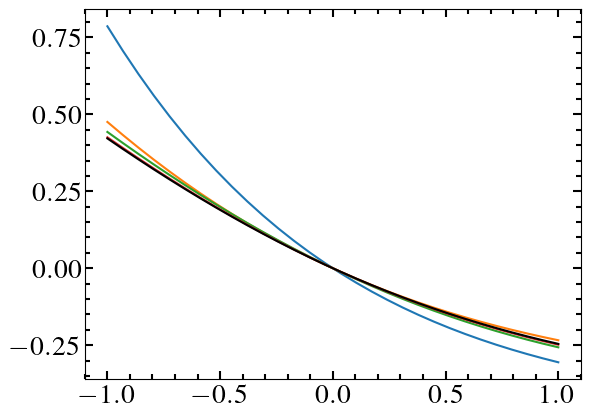

In [16]:
plt.plot(Fig_2c_slist, Fig_2c_theta_list[0])
plt.plot(Fig_2c_slist, Fig_2c_theta_list[1])
plt.plot(Fig_2c_slist, Fig_2c_theta_list[2])
plt.plot(Fig_2c_slist, Fig_2c_theta_list[3])


plt.plot(Fig_2c_slist, Fig_2c_exact_theta, color="black")

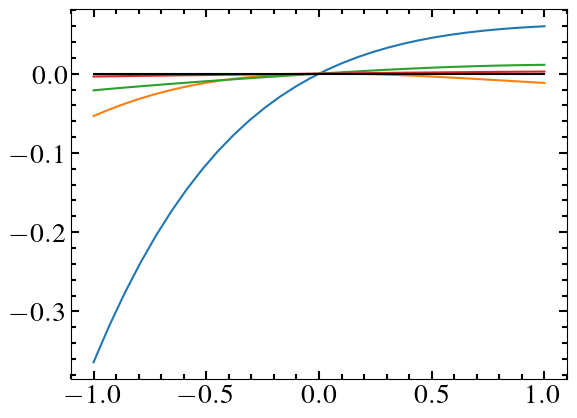

In [19]:
plt.plot(Fig_2c_slist, Fig_2c_exact_theta-Fig_2c_theta_list[0])
plt.plot(Fig_2c_slist, Fig_2c_exact_theta-Fig_2c_theta_list[1])
plt.plot(Fig_2c_slist, Fig_2c_exact_theta-Fig_2c_theta_list[2])
plt.plot(Fig_2c_slist, Fig_2c_exact_theta-Fig_2c_theta_list[3])


plt.plot(Fig_2c_slist, Fig_2c_exact_theta-Fig_2c_exact_theta, color="black")